In [10]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

# Explore Data

## News

In [2]:
column_names = ['News_id', 'Category', 'Subcategory', 'Title', 'Abstract', 'URL', 'Title_Entities', 'Abstract_Entities']
news = pd.read_csv('../data/train_news.tsv', sep='\t', names=column_names)
# news = pd.read_csv('../data/train_news_processed.csv')
news.head()

,News_id,Category,Subcategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N621266,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N318047,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N162003,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N603780,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N652304,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


### Info

In [32]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   News_id            101527 non-null  object
 1   Category           101527 non-null  object
 2   Subcategory        101527 non-null  object
 3   Title              101527 non-null  object
 4   Abstract           96112 non-null   object
 5   URL                101527 non-null  object
 6   Title_Entities     101524 non-null  object
 7   Abstract_Entities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB


### Duplicate

In [5]:
news[news.duplicated()].shape[0]

0

In [6]:
news[news.duplicated(subset='Title')].shape[0]

3139

In [7]:
news[news.duplicated(subset=['Title', 'Abstract'])].shape[0]

2292

In [8]:
news = news.drop_duplicates(subset='Title')

### Missing

In [9]:
news.isna().sum()

News_id                 0
Category                0
Subcategory             0
Title                   0
Abstract             5343
URL                     0
Title_Entities          3
Abstract_Entities       6
dtype: int64

### Category

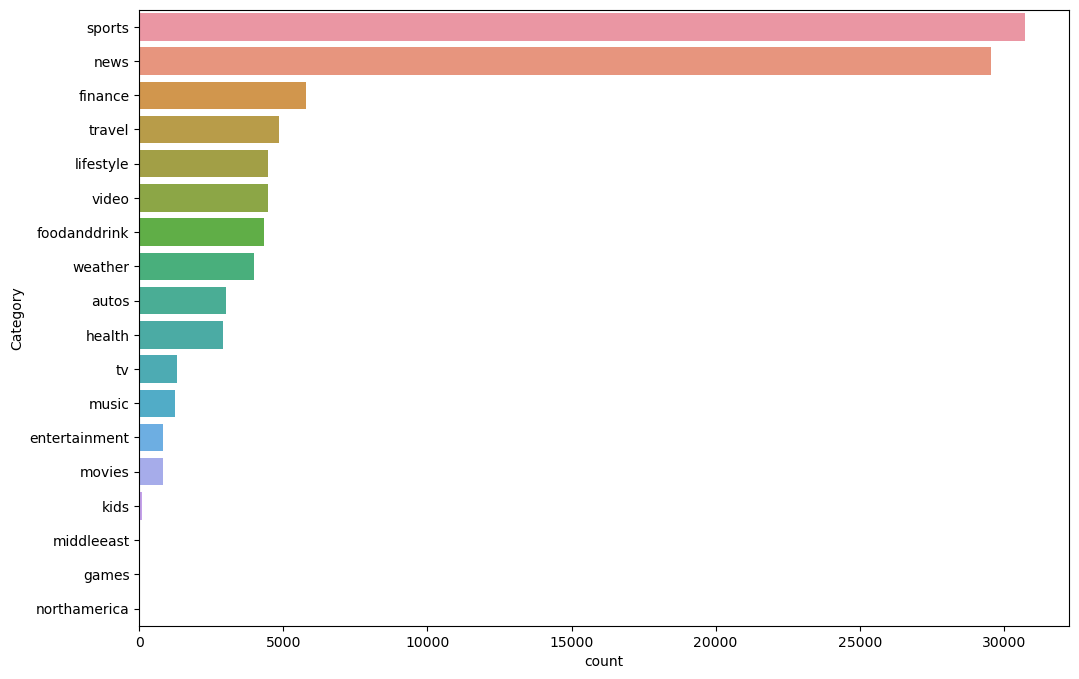

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(data=news, y='Category', order=news['Category'].value_counts().index)
plt.show()

### Subcategory

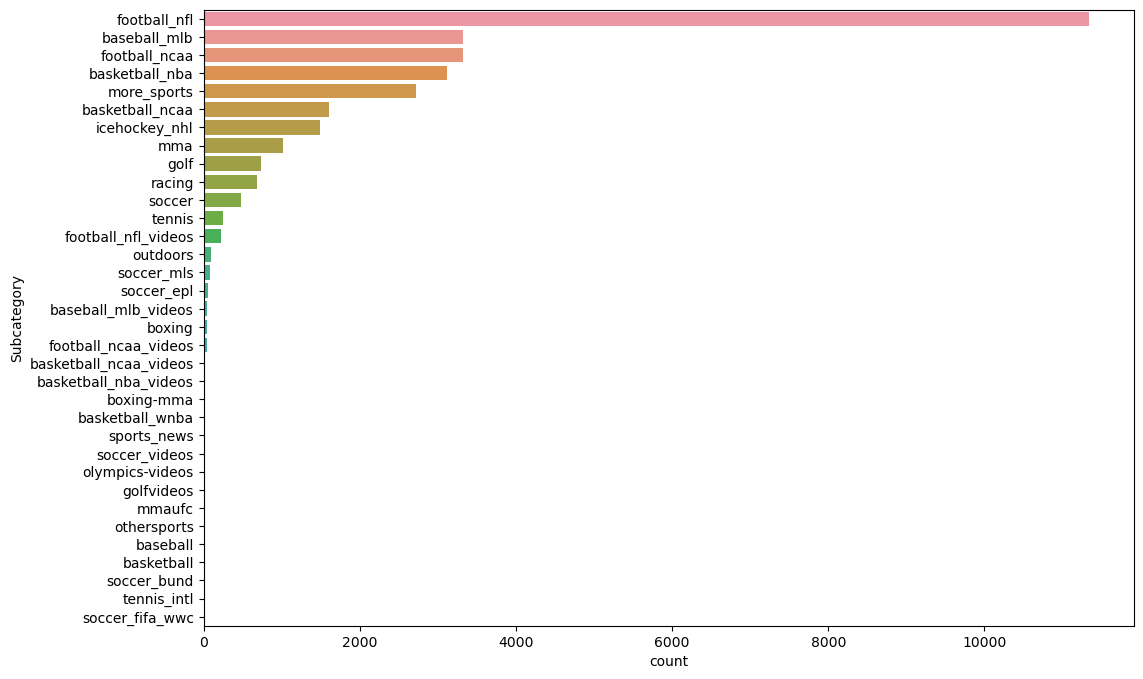

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(data=news[news['Category']=='sports'], y='Subcategory', order=news[news['Category']=='sports']['Subcategory'].value_counts().index)
plt.show()

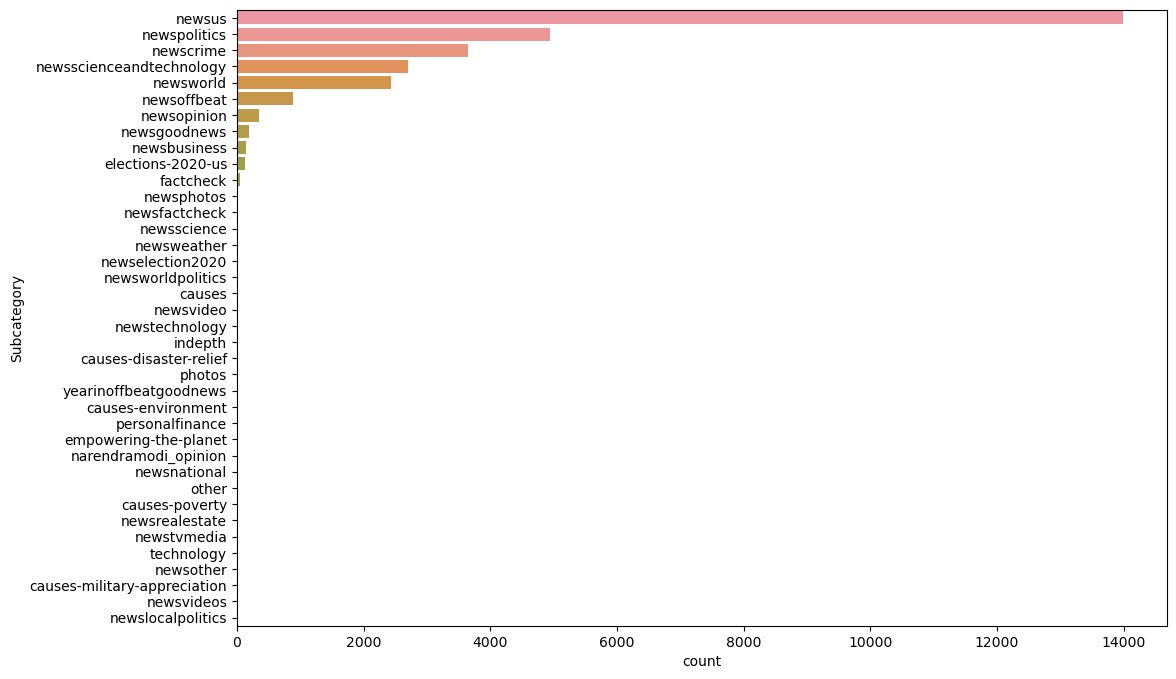

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(data=news[news['Category']=='news'], y='Subcategory', order=news[news['Category']=='news']['Subcategory'].value_counts().index)
plt.show()

### Title

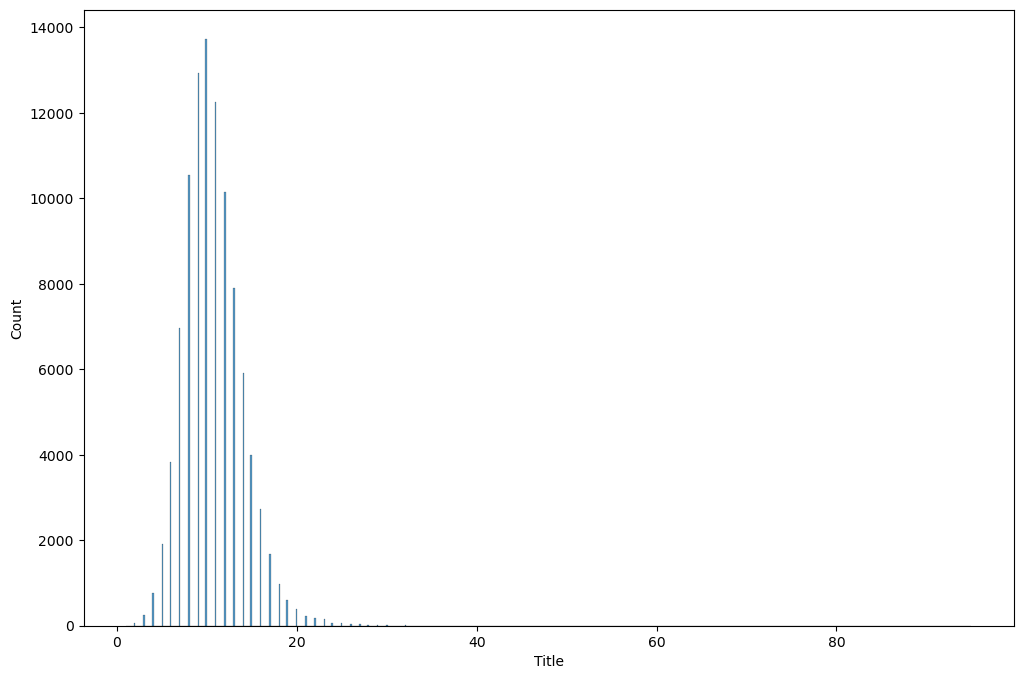

In [13]:
plt.figure(figsize=(12, 8))
sns.histplot(x=news['Title'].apply(lambda x: len(x.split())))
plt.show()

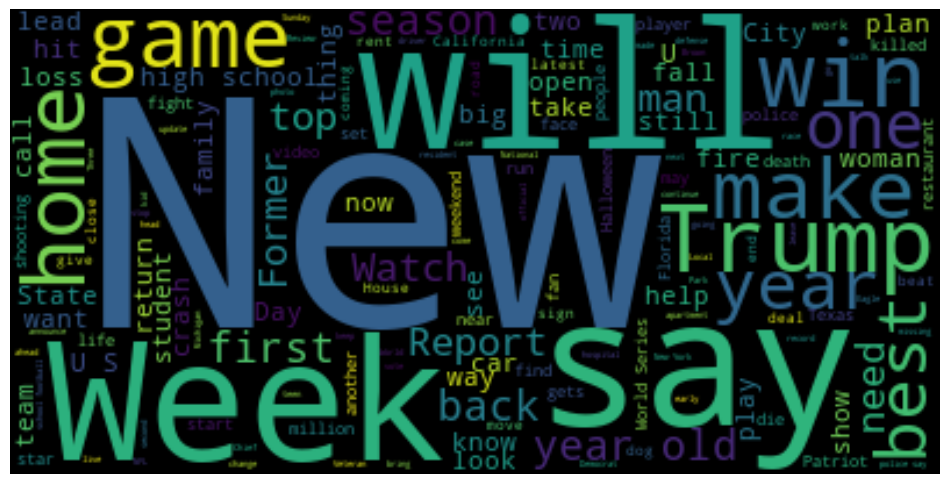

In [14]:
text = ' '
for i in news['Title']:
    text += i + ' '

wordcloud = WordCloud().generate(text=text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

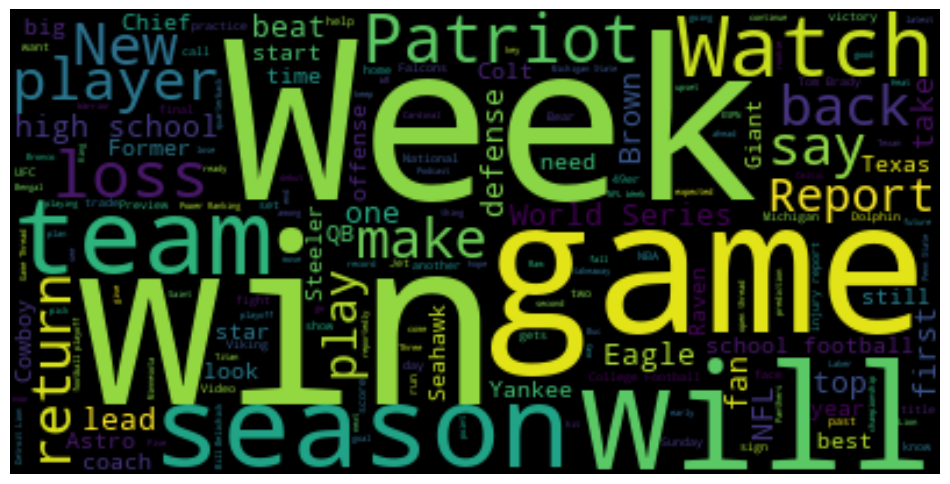

In [15]:
text = ' '
for i in news[news['Category']=='sports']['Title']:
    text += i + ' '

wordcloud = WordCloud().generate(text=text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

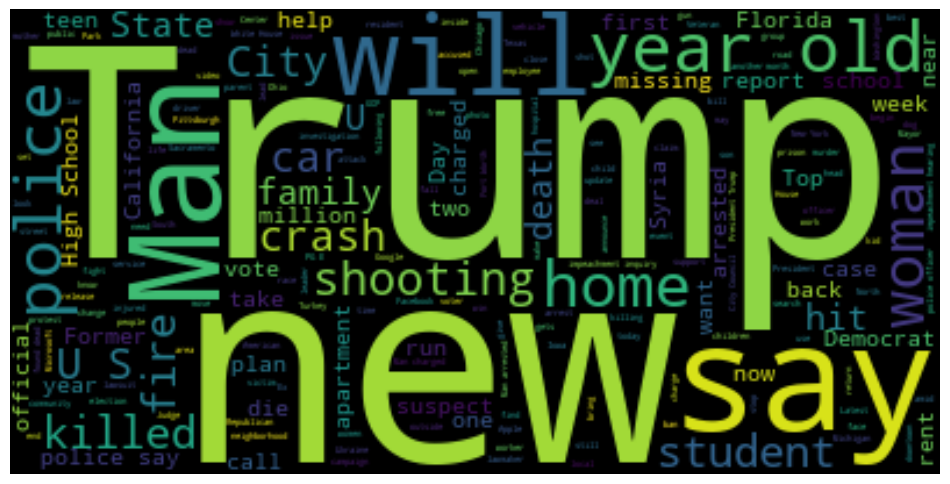

In [16]:
text = ' '
for i in news[news['Category']=='news']['Title']:
    text += i + ' '

wordcloud = WordCloud().generate(text=text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word2Vec

In [17]:
vectorizer = CountVectorizer()
print(vectorizer.fit_transform(news['Title'].fillna(' ').values).get_shape())
vectorizer = TfidfVectorizer()
print(vectorizer.fit_transform(news['Title'].fillna(' ').values).get_shape())
vectorizer = HashingVectorizer()
print(vectorizer.fit_transform(news['Title'].fillna(' ').values).get_shape())

(98388, 40990)
(98388, 40990)
(98388, 1048576)


In [18]:
vectorizer = CountVectorizer()
print(vectorizer.fit_transform(news['Abstract'].fillna(' ').values).get_shape())
vectorizer = TfidfVectorizer()
print(vectorizer.fit_transform(news['Abstract'].fillna(' ').values).get_shape())
vectorizer = HashingVectorizer()
print(vectorizer.fit_transform(news['Abstract'].fillna(' ').values).get_shape())

(98388, 68994)
(98388, 68994)
(98388, 1048576)


## Behaviors

In [3]:
column_names = ['Impression_id', 'User', 'Time', 'Clicked_News', 'Impressions']
behaviors = pd.read_csv('../data/train_behaviors.tsv', sep='\t', names=column_names, parse_dates=['Time'])
behaviors.head()

,Impression_id,User,Time,Clicked_News,Impressions
0,0,U1349561,2019-11-11 09:31:08,N410559 N109405 N79284 N812877 N311012 N362483...,N383574-0 N727666-0 N169045-0 N846428-0 N70382...
1,1,U2788121,2019-11-09 09:13:19,N642952 N253717 N857922 N684266 N291776 N12107...,N184823-0 N107900-0 N29500-0 N122187-0 N487132...
2,2,U686145,2019-11-12 06:21:28,N900496 N118253 N510477 N167498 N693772,N499466-0 N665940-0 N394508-1 N386423-0 N39675...
3,3,U2794941,2019-11-13 09:30:05,N417895,N96322-0 N909778-0 N656987-0 N594694-0 N306259...
4,4,U1838845,2019-11-10 05:03:16,N187833 N272183 N482344 N65242 N211696 N194448...,N27904-0 N731054-0 N281766-0 N177459-0 N768567...


### Info

In [35]:
behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285297 entries, 0 to 285296
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Impression_id  285297 non-null  int64         
 1   User           285297 non-null  object        
 2   Time           285297 non-null  datetime64[ns]
 3   Clicked_News   285297 non-null  object        
 4   Impressions    285297 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 10.9+ MB


In [36]:
print('number of unique values')
for col in behaviors.columns:
    print(f'    {col}: {behaviors[col].nunique()}')

number of unique values
    Impression_id: 285297
    User: 213250
    Time: 194710
    Clicked_News: 211759
    Impressions: 285297


### Duplicate

In [37]:
behaviors[behaviors.duplicated()].shape[0]

0

In [38]:
behaviors[behaviors.duplicated(subset=['User', 'Clicked_News', 'Time'])].shape[0]

4

### Clicked News

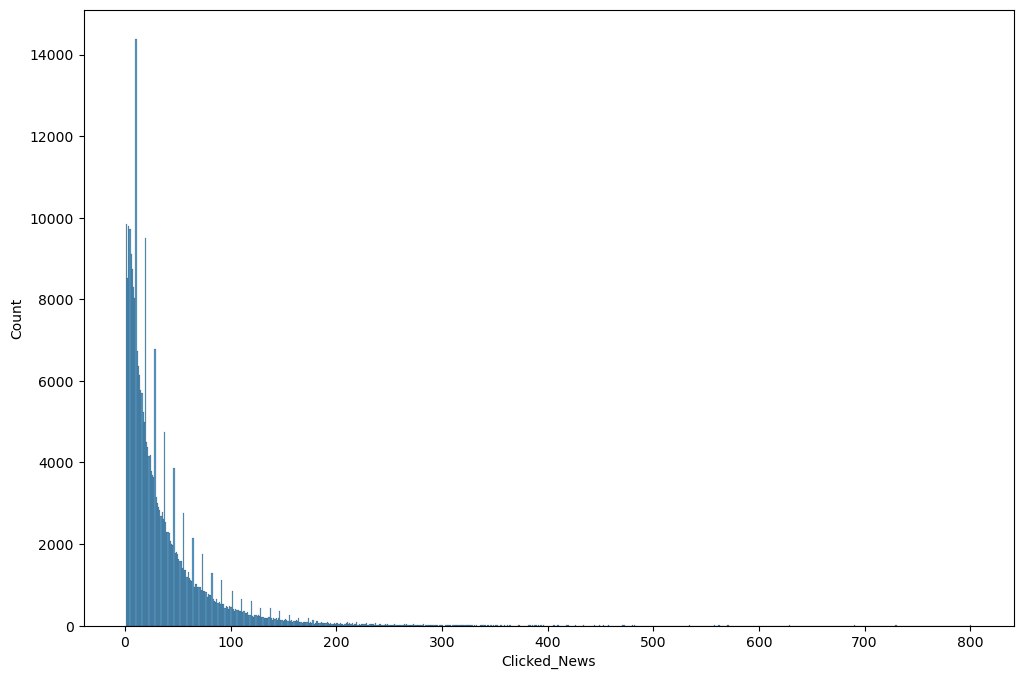

In [39]:
plt.figure(figsize=(12, 8))
sns.histplot(x=behaviors['Clicked_News'].apply(lambda x: len(x.split())))
plt.show()

### Target News / Target News Clicked

In [4]:
candidate_pairs = behaviors['Impressions'].str.split(expand=True)
for col in candidate_pairs.columns:
    candidate_pairs[['Article '+str(col), 'label '+str(col)]] = candidate_pairs[col].str.split(pat='-', expand=True)
behaviors['Target_News'] = candidate_pairs[['Article '+str(i) for i in range(15)]].agg(' '.join, axis=1)
behaviors['Target_News_Clicked'] = candidate_pairs[['label '+str(i) for i in range(15)]].agg(' '.join, axis=1)

del candidate_pairs

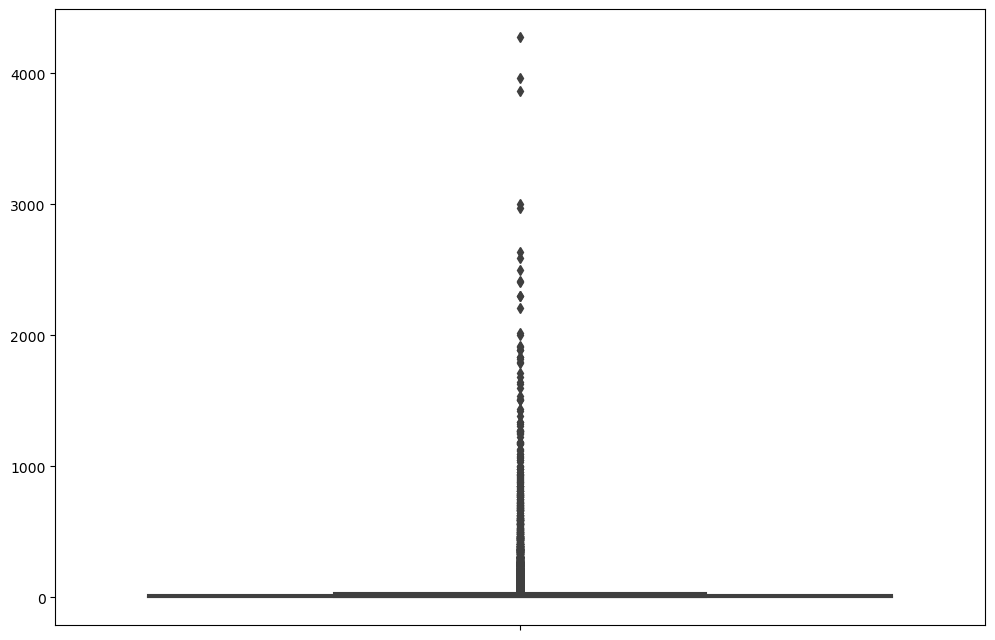

In [41]:
clicked = behaviors['Target_News_Clicked'].apply(lambda x: x.split())
indices = clicked.apply(lambda x: [i for i in range(len(x)) if x[i]=='1'])
x = behaviors['Target_News'].str.split()
target_clicked = []
for i in range(len(x)):
    for j in indices[i]:
        target_clicked.append(x[i][j])
target_clicked = pd.Series(target_clicked)

plt.figure(figsize=(12, 8))
sns.boxplot(y=target_clicked.value_counts())
plt.show()

# Preprocessing

In [5]:
candidate_pairs = behaviors['Impressions'].str.split(expand=True)
for col in candidate_pairs.columns:
    candidate_pairs[['Article '+str(col), 'label '+str(col)]] = candidate_pairs[col].str.split(pat='-', expand=True)
behaviors['Target_News'] = candidate_pairs[['Article '+str(i) for i in range(15)]].agg(' '.join, axis=1)
behaviors['Target_News_Clicked'] = candidate_pairs[['label '+str(i) for i in range(15)]].agg(' '.join, axis=1)

del candidate_pairs

In [5]:
news_id2index_map = {id: index+1 for index, id in enumerate(news['News_id'].unique())}
user_id2index_map = {id: index+1 for index, id in enumerate(behaviors['User'].unique())}

In [6]:
news['News_index'] = news['News_id'].map(lambda x: news_id2index_map[x])
behaviors['Clicked_News_index'] = behaviors['Clicked_News'].map(lambda x: [news_id2index_map[id] for id in x.split()])
behaviors['Target_News_index'] = behaviors['Target_News'].map(lambda x: [news_id2index_map[id] for id in x.split()])
behaviors['User_index'] = behaviors['User'].map(lambda x: user_id2index_map[x])

In [7]:
title_vectorizer = TfidfVectorizer()
title_vector = title_vectorizer.fit_transform(news['Title'].fillna(' ').values)

In [8]:
def get_vec(x):
    indices = [news[news['News_index']==i].index[0] for i in x]
    
    return csr_matrix(title_vector[indices].mean(axis=0))

get_vec(behaviors['Clicked_News_index'][0]).get_shape()

(1, 40990)

In [11]:
news_clicked_vector_list = []

for i in trange(len(behaviors['Clicked_News_index'])):
    indices = [news[news['News_index']==j].index[0] for j in behaviors['Clicked_News_index'][i]]
    news_clicked_vector_list.append(csr_matrix(title_vector[indices].mean(axis=0)))

x1 = scipy.sparse.hstack(news_clicked_vector_list)
scipy.sparse.save_npz('../data/Clicked_News_Vector.npz', x1)

100%|██████████| 285297/285297 [52:44<00:00, 90.16it/s]  


In [15]:
news_target_vector_list = []

for i in trange(len(behaviors['Target_News_index'])):
    indices = [news[news['News_index']==j].index[0] for j in behaviors['Target_News_index'][i]]
    news_target_vector_list.append(csr_matrix(title_vector[indices].mean(axis=0)))

x2 = scipy.sparse.hstack(news_clicked_vector_list)
scipy.sparse.save_npz('../data/Target_News_Vector.npz', x2)

100%|██████████| 285297/285297 [20:52<00:00, 227.79it/s]


In [16]:
x1 = scipy.sparse.load_npz('../data/Clicked_News_Vector.npz')
x2 = scipy.sparse.load_npz('../data/Target_News_Vector.npz')

# Train

In [ ]:
class News(Dataset):
    def __init__(self, x) -> None:
        super().__init__()

        self.x = x

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index]

In [ ]:
class NewsNetwork(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.fc1 = torch.nn.Linear(in_features=kwargs['input_dim'], out_features=kwargs['hidden_dim'])
        self.fc2 = torch.nn.Linear(in_features=kwargs['hidden_dim'], out_features=kwargs['hidden_dim'])
        self.fc3 = torch.nn.Linear(in_features=kwargs['hidden_dim'], out_features=kwargs['output_dim'])

        self.activation = torch.nn.ReLU()

    def forward(self, **kwargs):
        x = self.activation(self.fc1(kwargs['input']))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

In [ ]:
class Recommend(Dataset):
    def __init__(self, df) -> None:
        super().__init__()

        self.x
        self.y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
class RecommendNetwork(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.fc1 = torch.nn.Linear(in_features=kwargs['input_dim'], out_features=kwargs['hidden_dim'])
        self.fc2 = torch.nn.Linear(in_features=kwargs['hidden_dim'], out_features=kwargs['hidden_dim'])
        self.fc3 = torch.nn.Linear(in_features=kwargs['hidden_dim'], out_features=kwargs['output_dim'])

        self.activation = torch.nn.ReLU()
        self.activation2 = torch.nn.Softmax()

    def forward(self, **kwargs):
        x = self.activation(self.fc1(kwargs['input']))
        x = self.activation(self.fc2(x))
        x = self.activation2(self.fc3(x))
        return x